### Starbucks Capstone Challenge
# Data Exploration and Feature Engineering

This notebook aims to explore the data set available and generate features to use in machine learning models.  
To do so, it involves two main concepts:

#### Exploratory Data Analysis  
Data exploration is one of the most important parts of the machine learning workflow because it allows you to notice any initial patterns in data distribution and features that may inform how to proceed with modeling and clustering the data.  

Data exploration uses visual exploration to understand what is in a dataset and the characteristics of the data. These characteristics can include size or amount of data, completeness and correctness of the data, and possible relationships amongst data elements.


#### Feature Engineering  
It is the process of determining which features might be useful in training a model, and then converting raw data from log files and other sources into said features.

In [1]:
## Import all the necessary libraries
import base64
import os
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display_html
from matplotlib.figure import Figure
from sklearn.preprocessing import minmax_scale

In [2]:
## Global definitions

data_dir = 'data'

pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

portfolio_data_path = os.path.join(data_dir, 'portfolio.json')
profile_data_path = os.path.join(data_dir, 'profile.json')
transcript_data_path = os.path.join(data_dir, 'transcript.json')

In [3]:
## global functions

def load_dataframe(data_path):
    """Create a dataframe from a json file"""
    return pd.read_json(data_path, orient='records', lines=True)


def convert_fig_to_html(figure):
    """
    Convert a given matplotlib figure to HTML code
    
    Attributes:
    figure (matplotlib.figure.Figure): Generated without using pyplot.
    
    Return:
    return: img-html tag containing the figure data
    """
    # Save figure to a temporary buffer
    buf = BytesIO()
    figure.savefig(buf, format="png")
    # Embed the result in the html output
    data = base64.b64encode(buf.getbuffer()).decode("ascii")
    return f'<img src="data:image/png;base64,{data}" ' \
            'style="display:inline;top:0%"/>'

# Portfolio data set
Data set containing information about the offers which can be sent to users

## Overview

In [4]:
portfolio_df = load_dataframe(portfolio_data_path)
display(portfolio_df)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Transformation
As we can see **offer type** is a categorical feature that could be mapped as one hot encoding.  

**Channels** are categorical feature as well, but values can assume more than one category. Its values may be converted into individual features.  

**Reward**, **difficulty**, and **duration** are numerical features which should be scaled. As they are expressed in monetary units, reward and difficulty should share the same scale.

In [5]:
## Set id as index
portfolio_df.set_index(keys='id', verify_integrity=True, inplace=True)

## Make offer_type one hot encoded
portfolio_df = portfolio_df.join(
    pd.get_dummies(portfolio_df.pop('offer_type')))

## Transform channels in distinct features
channels_df = pd.DataFrame(portfolio_df.pop('channels'))
channels_df = channels_df.explode('channels')
channels_df = channels_df.assign(value=lambda x: 1)
channels_df = channels_df.pivot(columns='channels', values='value')
channels_df.fillna(value=0, inplace=True)
portfolio_df = portfolio_df.join(channels_df)
channels_df = None

## Scale reward, difficulty, and duration
# reward and difficulty share the same scale
portfolio_df[['reward', 'difficulty']] /= \
    portfolio_df[['reward', 'difficulty']].to_numpy().max()
portfolio_df.duration = minmax_scale(portfolio_df.duration)

## print the result
display(portfolio_df)

,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,0.50,0.50,0.57,1,0,0,1.0,1.0,1.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.50,0.50,0.29,1,0,0,1.0,1.0,1.0,1.0
3f207df678b143eea3cee63160fa8bed,0.00,0.00,0.14,0,0,1,1.0,1.0,0.0,1.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.25,0.25,0.57,1,0,0,1.0,1.0,0.0,1.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.25,1.00,1.00,0,1,0,1.0,0.0,0.0,1.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.15,0.35,0.57,0,1,0,1.0,1.0,1.0,1.0
fafdcd668e3743c1bb461111dcafc2a4,0.10,0.50,1.00,0,1,0,1.0,1.0,1.0,1.0
5a8bc65990b245e5a138643cd4eb9837,0.00,0.00,0.00,0,0,1,1.0,1.0,1.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,0.25,0.25,0.29,1,0,0,1.0,1.0,1.0,1.0


## Analysis

In [6]:
print('Missing data: {}\n'.format(portfolio_df.isna().any().any()))

print('Dataset description:')
display(pd.DataFrame(portfolio_df.describe()))

print('Pairwise correlation')
display(portfolio_df.corr().abs().round(2))

Missing data: False

Dataset description:


,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
count,10.00,10.00,10.00,10.00,10.00,10.00,10.0,10.00,10.00,10.00
mean,0.21,0.39,0.50,0.40,0.40,0.20,1.0,0.90,0.60,0.80
std,0.18,0.29,0.33,0.52,0.52,0.42,0.0,0.32,0.52,0.42
min,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00
25%,0.10,0.25,0.29,0.00,0.00,0.00,1.0,1.00,0.00,1.00
50%,0.20,0.42,0.57,0.00,0.00,0.00,1.0,1.00,1.00,1.00
75%,0.25,0.50,0.57,1.00,1.00,0.00,1.0,1.00,1.00,1.00
max,0.50,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00


Pairwise correlation


,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
reward,1.00,0.47,0.16,0.79,0.29,0.62,NaN,0.08,0.29,0.12
difficulty,0.47,1.00,0.81,0.03,0.60,0.70,NaN,0.74,0.15,0.24
duration,0.16,0.81,1.00,0.19,0.74,0.68,NaN,0.53,0.19,0.34
bogo,0.79,0.03,0.19,1.00,0.67,0.41,NaN,0.27,0.25,0.10
discount,0.29,0.60,0.74,0.67,1.00,0.41,NaN,0.41,0.17,0.41
informational,0.62,0.70,0.68,0.41,0.41,1.00,NaN,0.17,0.10,0.37
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile,0.08,0.74,0.53,0.27,0.41,0.17,NaN,1.00,0.41,0.17
social,0.29,0.15,0.19,0.25,0.17,0.10,NaN,0.41,1.00,0.41
web,0.12,0.24,0.34,0.10,0.41,0.37,NaN,0.17,0.41,1.00


## Resulting dataset

In [7]:
display(portfolio_df.sort_values(by=['discount', 'bogo', 'reward', 'difficulty']))

,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
id,,,,,,,,,,
3f207df678b143eea3cee63160fa8bed,0.00,0.00,0.14,0,0,1,1.0,1.0,0.0,1.0
5a8bc65990b245e5a138643cd4eb9837,0.00,0.00,0.00,0,0,1,1.0,1.0,1.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.25,0.25,0.57,1,0,0,1.0,1.0,0.0,1.0
f19421c1d4aa40978ebb69ca19b0e20d,0.25,0.25,0.29,1,0,0,1.0,1.0,1.0,1.0
ae264e3637204a6fb9bb56bc8210ddfd,0.50,0.50,0.57,1,0,0,1.0,1.0,1.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.50,0.50,0.29,1,0,0,1.0,1.0,1.0,1.0
fafdcd668e3743c1bb461111dcafc2a4,0.10,0.50,1.00,0,1,0,1.0,1.0,1.0,1.0
2906b810c7d4411798c6938adc9daaa5,0.10,0.50,0.57,0,1,0,1.0,1.0,0.0,1.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.15,0.35,0.57,0,1,0,1.0,1.0,1.0,1.0


# Profile data set
Data set containing demographic data for each rewards program users

## Overview

In [8]:
profile_df = load_dataframe(profile_data_path)
display(profile_df.head())

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


## Exploration

### Analyzing the missing values
At a glance, it is possible to notice empty values in columns **income** and **gender**, as well as missing value encoded as 118 in the column **age**.  
Also, aparently, those values are present in the same rows. It would be productive to verify if they always accur together.

In [9]:
display(pd.DataFrame(profile_df.count()).T \
        .style.set_caption('Counting not null features'))

display(profile_df.describe().T.round(2) \
        .style.set_caption('Dataframe description'))

display(pd.DataFrame(profile_df.gender.value_counts()).T \
        .style.set_caption('Gender by user'))

print('\nInvestigating whether all missing values are in the same rows.')
gender_isna = profile_df.gender.isna()
income_isna = profile_df.income.isna()
age_missing = profile_df.age == 118

print('Gender:\tnumber of NA: \t', gender_isna.sum())
print('Income:\tnumber of NA: \t', income_isna.sum())
print('Age:\tmissing values:\t', age_missing.sum())

print('\nAre gender and income missing in the same rows?\t{}' \
      .format(gender_isna.isin(income_isna).all()))
print('Are gender and age missing in the same rows?\t{}' \
      .format(gender_isna.isin(age_missing).all()))
print('Are income and age missing in the same rows?\t{}' \
      .format(income_isna.isin(age_missing).all()))

display(pd.DataFrame(profile_df.became_member_on[gender_isna])\
        .describe().T.style.set_caption('When did they register?'))
display(pd.DataFrame(profile_df.became_member_on[~gender_isna])\
        .describe().T.style.set_caption('When did other users register?'))

,gender,age,id,became_member_on,income
0,14825,17000,17000,17000,14825


,count,mean,std,min,25%,50%,75%,max
age,17000.00,62.53,26.74,18.00,45.00,58.00,73.00,118.00
became_member_on,17000.00,20167034.23,11677.50,20130729.00,20160526.00,20170802.00,20171230.00,20180726.00
income,14825.00,65404.99,21598.30,30000.00,49000.00,64000.00,80000.00,120000.00


,M,F,O
gender,8484,6129,212



Investigating whether all missing values are in the same rows.
Gender:	number of NA: 	 2175
Income:	number of NA: 	 2175
Age:	missing values:	 2175

Are gender and income missing in the same rows?	True
Are gender and age missing in the same rows?	True
Are income and age missing in the same rows?	True


,count,mean,std,min,25%,50%,75%,max
became_member_on,2175.00,20168036.78,10091.05,20130802.00,20160704.50,20170731.00,20171226.00,20180726.00


,count,mean,std,min,25%,50%,75%,max
became_member_on,14825.00,20166887.15,11885.65,20130729.00,20160520.00,20170802.00,20171230.00,20180726.00


By analyzing data above, it is possible to conclude that all the missing values occur in the same rows.  
This may have several possible causes, for instance:  
* the interface where those profiles were created might not have requested those information to be input, or
* those users may not have agreeded with the privacy policy.  

In addition to that, those users have been signing up all over the analyzed period in the same fashion than the other users.  

Altough those users could be filtered out of the data set, since they represent 14,6% of the users, they might have some peculiar behaviour which would be interesting to be analyzed.
Thus, my approach with those record is:  
* maintain those records in the data set
* mark those users as belonging to a particular class, by creating a new feature for that
* since gender is a discrete feature, create another gender category
* as age and income are continuous features, fill them with the respective mean values

These changes will be applied during the next Transformation section.

### Explore ages

,age
count,14825.00
mean,54.39
std,17.38
min,18.00
25%,42.00
50%,55.00
75%,66.00
max,101.00

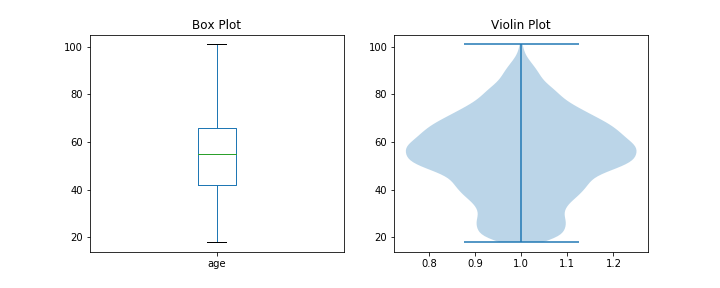

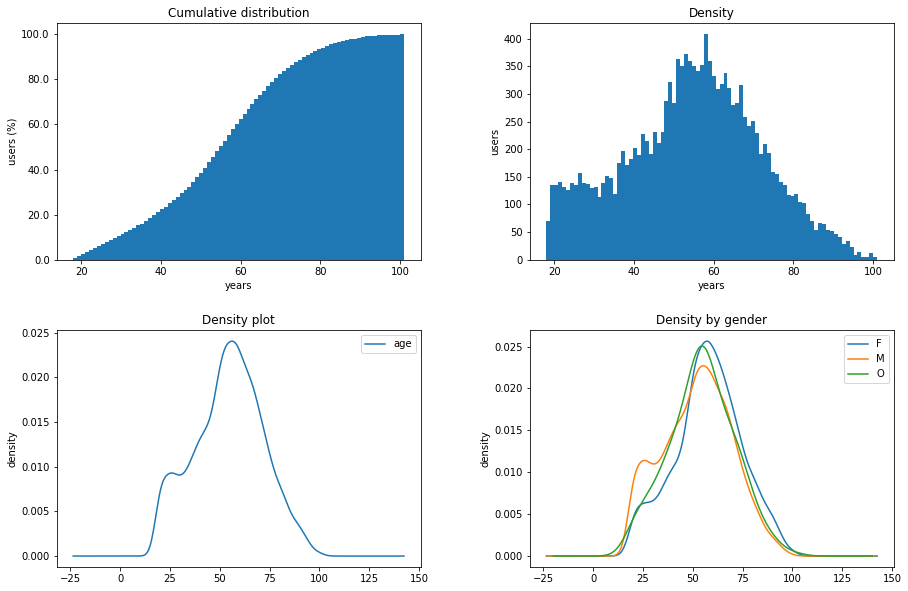

In [11]:
## Select registers with valid age
age_df = pd.DataFrame(profile_df.age[~age_missing])

## Generate the registers' description
description_pdstyle = \
    pd.DataFrame(age_df.describe()).style \
    .set_caption('Ages description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Generate box and violin plots
fig1 = Figure(figsize=(10,4))
axs = fig1.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].set_title('Box Plot')
age_df.plot.box(ax=axs[0])
axs[1].violinplot(age_df.values)
axs[1].set_title('Violin Plot')

## Generate histograms
bins = 84
fig2, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()

# Cumulative distribution
age_df.hist(bins=bins, ax=axs[0], cumulative=True, density=True)
axs[0].set_title('Cumulative distribution')
axs[0].set_ylabel('users (%)')
axs[0].set_yticklabels((axs[0].get_yticks()*100).round(0))
axs[0].set_xscale('linear')
axs[0].set_xlabel('years')
axs[0].grid(False)

# Histogram
age_df.hist(bins=bins, ax=axs[1])
axs[1].set_title('Density')
axs[1].set_ylabel('users')
axs[1].set_xscale('linear')
axs[1].set_xlabel('years')
axs[1].grid(False)

# density
age_df.plot.density(ax=axs[2])
axs[2].legend()
axs[2].set_title('Density plot')
axs[2].set_ylabel('density')
axs[2].grid(False)

age_gender_df = profile_df[~age_missing].groupby('gender').age
age_gender_df.plot.density(ax=axs[3])
axs[3].set_title('Density by gender')
axs[3].set_ylabel('density')
axs[3].legend()
axs[3].grid(False)


## Display the information generated above
display_html('<center>' \
              + description_pdstyle._repr_html_() \
              + convert_fig_to_html(fig1) \
              + '</center>',
             raw=True)
plt.show()

Analyzing the graphs above, we can see that although the age is normally distributed among the population, there is a local peak around the interval 20 ~ 25 for both male and female genders. Apparently, this deviation is not a problem to be handled beforehand. However, this is a point to be taken into consideration if networks have difficulty to converge.

### Explore income

,income
count,14825
mean,65405
std,21598.3
min,30000
25%,49000
50%,64000
75%,80000
max,120000

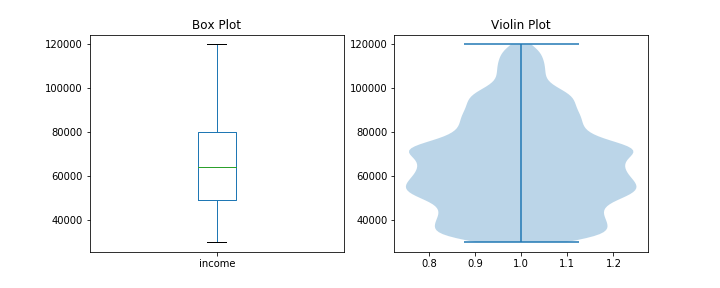

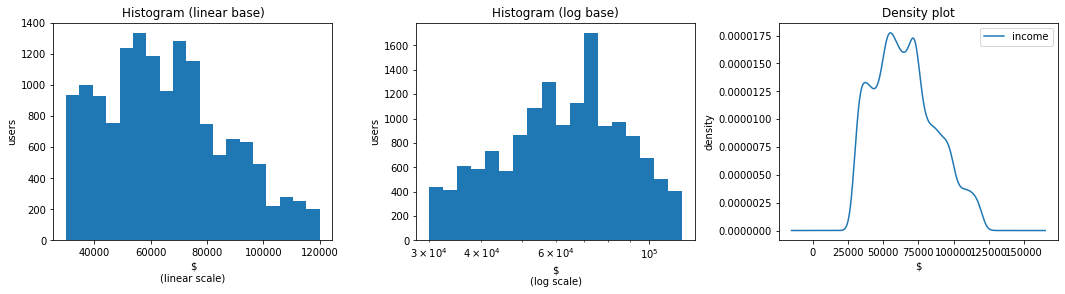

In [11]:
## Select registers with valid income
income_df = pd.DataFrame(profile_df.income[~income_isna])

## Generate the registers' description
description_pdstyle = \
    pd.DataFrame(income_df.describe()).style \
    .set_caption('Income description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Generate box and violin plots
fig1 = Figure(figsize=(10,4))
axs = fig1.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].set_title('Box Plot')
income_df.plot.box(ax=axs[0])
axs[1].violinplot(income_df.values)
axs[1].set_title('Violin Plot')

## Generate histograms
bins = 19
logbins = np.logspace(np.log10(income_df.min().min()),
                      np.log10(income_df.max().max()),
                      num=bins)
fig2, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
axs = axs.flatten()

# linear scale
income_df.hist(bins=bins, ax=axs[0])
axs[0].set_title('Histogram (linear base)')
axs[0].set_ylabel('users')
axs[0].set_xscale('linear')
axs[0].set_xlabel('$\n(linear scale)')
axs[0].grid(False)

# log scale
income_df.hist(bins=logbins, ax=axs[1])
axs[1].set_title('Histogram (log base)')
axs[1].set_ylabel('users')
axs[1].set_xscale('log')
axs[1].set_xlabel('$\n(log scale)')
axs[1].grid(False)

# density x log scale
a = income_df.plot.density(ax=axs[2])
axs[2].set_title('Density plot')
axs[2].set_ylabel('density')
axs[2].set_xlabel('$')
axs[2].grid(False)

# Display the information generated above
display_html('<center>' \
              + description_pdstyle._repr_html_() \
              + convert_fig_to_html(fig1) \
              + '</center>',
             raw=True)
plt.show()

### Explore membership

,became_member_on
count,17000
mean,2.0167e+07
std,11677.5
min,2.01307e+07
25%,2.01605e+07
50%,2.01708e+07
75%,2.01712e+07
max,2.01807e+07
,became_member_on
count,17000

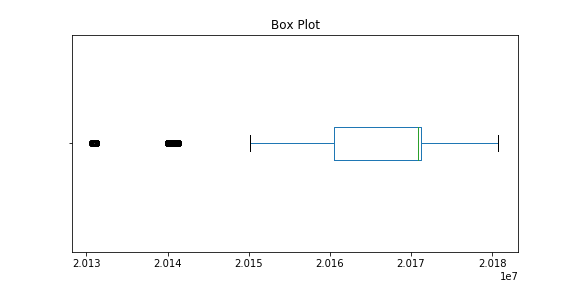

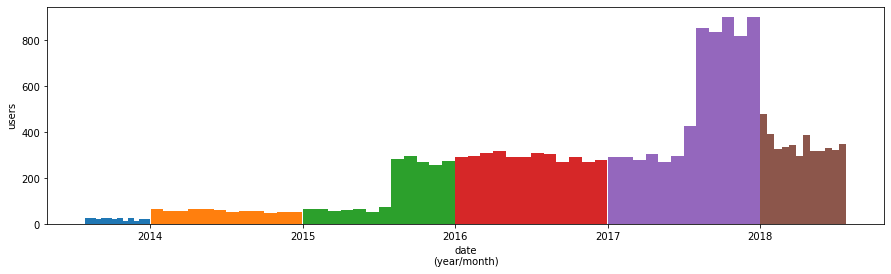

In [12]:
## Select registers
membership_df = profile_df.became_member_on

# Generate box plot
fig1 = Figure(figsize=(8,4))
ax = fig1.subplots()
ax.set_title('Box Plot')
membership_df.plot.box(ax=ax, vert=False)
ax.set_yticklabels('')

# Generate registers' description
member_desc_integers_pdstyle = \
    pd.DataFrame(membership_df.describe()).style \
    .set_caption('Membership description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Convert data to datetime format
membership_df = pd.to_datetime(membership_df, format='%Y%m%d')

# Generate registers' description
member_desc_datetime_pdstyle = \
    pd.DataFrame(membership_df.describe()).style \
    .set_caption('Membership description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Generate histograms
bins = 12
fig2, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

membership_df.groupby(membership_df.dt.year) \
    .hist(bins=bins, ax=ax)
ax.set_ylabel('users')
ax.set_xlabel('date\n(year/month)')
ax.grid(False)

## Display the information generated above
display_html('<center>' \
              + member_desc_integers_pdstyle._repr_html_() \
              + ' '
              + member_desc_datetime_pdstyle._repr_html_() \
              + convert_fig_to_html(fig1) \
              + '</center>',
             raw=True)
plt.show()

## Transformation
* mark those users as belonging to a particular class, by creating a new feature for that
* since gender is a discrete feature, create another gender category
* as age and income are continuous features, fill them with the respective mean values

In [13]:
# create new feature to indicate missing values
profile_df = profile_df.assign(missing_data=age_missing.astype(int))

# fill gender if a new 'U' (unknown) category
profile_df.gender.mask(gender_isna, 'U', inplace=True)

# fill age and income with its respective mean values
profile_df.age.mask(age_missing, profile_df.age.mean(), inplace=True)
profile_df.income.mask(income_isna, profile_df.income.mean(), inplace=True)

# Make gender one-hot encoded
profile_df = profile_df.join(
    pd.get_dummies(profile_df.pop('gender')))

# Set id as index
profile_df.set_index(keys='id', verify_integrity=True, inplace=True)

# Normalize the values in dataframe
profile_df = pd.DataFrame(
    minmax_scale(profile_df),
    index=profile_df.index,
    columns=profile_df.columns)

In [14]:
print('Missing data: {}\n'.format(profile_df.isna().any().any()))

display(pd.DataFrame(profile_df.describe()).round(2).style \
        .set_caption('Dataset description'))

display(profile_df.corr().abs().style \
        .set_caption('Pairwise correlation'))

Missing data: False



,age,became_member_on,income,missing_data,F,M,O,U
count,17000,17000,17000,17000,17000,17000,17000,17000
mean,0.45,0.73,0.39,0.13,0.36,0.5,0.01,0.13
std,0.2,0.23,0.22,0.33,0.48,0.5,0.11,0.33
min,0,0,0,0,0,0,0,0
25%,0.33,0.6,0.23,0,0,0,0,0
50%,0.48,0.8,0.39,0,0,0,0,0
75%,0.57,0.81,0.51,0,1,1,0,0
max,1,1,1,1,1,1,1,1


,age,became_member_on,income,missing_data,F,M,O,U
age,1,0.00715397,0.302491,0.165152,0.0962696,0.201212,0.00705796,0.165152
became_member_on,0.00715397,1,0.0275722,0.0328852,0.000342178,0.0241401,0.0083018,0.0328852
income,0.302491,0.0275722,1,8.33313e-17,0.219704,0.208366,0.0117968,8.33313e-17
missing_data,0.165152,0.0328852,8.33313e-17,1,0.287602,0.382309,0.0430428,1
F,0.0962696,0.000342178,0.219704,0.287602,1,0.74945,0.0843779,0.287602
M,0.201212,0.0241401,0.208366,0.382309,0.74945,1,0.112163,0.382309
O,0.00705796,0.0083018,0.0117968,0.0430428,0.0843779,0.112163,1,0.0430428
U,0.165152,0.0328852,8.33313e-17,1,0.287602,0.382309,0.0430428,1


## Resulting dataset

In [15]:
display(profile_df.head(10))

,age,became_member_on,income,missing_data,F,M,O,U
id,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.536523,0.789707,0.393389,1.0,0.0,0.0,0.0,1.0
0610b486422d4921ae7d2bf64640c50b,0.445783,0.799768,0.911111,0.0,1.0,0.0,0.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,0.536523,0.999720,0.393389,1.0,0.0,0.0,0.0,1.0
78afa995795e4d85b5d9ceeca43f5fef,0.686747,0.795648,0.777778,0.0,1.0,0.0,0.0,0.0
a03223e636434f42ac4c3df47e8bac43,0.536523,0.801548,0.393389,1.0,0.0,0.0,0.0,1.0
e2127556f4f64592b11af22de27a7932,0.602410,0.994000,0.444444,0.0,0.0,1.0,0.0,0.0
8ec6ce2a7e7949b1bf142def7d0e0586,0.536523,0.803968,0.393389,1.0,0.0,0.0,0.0,1.0
68617ca6246f4fbc85e91a2a49552598,0.536523,0.805508,0.393389,1.0,0.0,0.0,0.0,1.0
389bc3fa690240e798340f5a15918d5c,0.566265,0.989659,0.255556,0.0,0.0,1.0,0.0,0.0


# Transcript data set
Event log containing records for transactions, offers received, offers viewed, and offers completed

## Overview

In [16]:
transcript_df = load_dataframe(transcript_data_path)
display(transcript_df.head())
display(pd.DataFrame(transcript_df.event.value_counts()).T \
        .assign(missing=transcript_df.event.isna().sum()) \
        .assign(total=transcript_df.count()) \
        .style.set_caption('Count events'))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


,transaction,offer received,offer viewed,offer completed,missing,total
event,138953,76277,57725,33579,0,306534


## Exploration

### Initial transformation

The first step to understand this data set is splitting the value column, so that it is possible to analyze the relationship between events and results.

In [17]:
transcript_df = transcript_df.join(
    pd.DataFrame.from_records(transcript_df.pop('value')))
transcript_df.offer_id.update(transcript_df.pop('offer id'))

display(pd.DataFrame().append([
    transcript_df.query('event=="offer received"').head(),
    transcript_df.query('event=="offer viewed"').head(),
    transcript_df.query('event=="transaction"').head(),
    transcript_df.query('event=="offer completed"').head(),
    transcript_df.query('person=="78afa995795e4d85b5d9ceeca43f5fef"').head()]))

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In the representative dataset above, we notice that:
* *offer received* and *offer viewed* have an associated *offer id*
* *transaction* has an amount value that indicates how much the customer spent
* *offer completed* is associated to a reward value
* every event is informed with person and time
* distinct events can occur to the same person at the same time (see registers 47582 and 47583)

So that, we need to check if these statements are always true.

### Search for missing values

In [18]:
display(pd.DataFrame(
    {'offer received':
         transcript_df.query('event=="offer received"').notna().all(),
     'offer viewed':
         transcript_df.query('event=="offer viewed"').notna().all(),
     'transaction':
         transcript_df.query('event=="transaction"').notna().all(),
     'offer completed':
         transcript_df.query('event=="offer completed"').notna().all()
    }).T.style.set_caption('Event has all the information provided?'))

display(pd.DataFrame(
    {'offer received':
         transcript_df.query('event=="offer received"').isna().all(),
     'offer viewed':
         transcript_df.query('event=="offer viewed"').isna().all(),
     'transaction':
         transcript_df.query('event=="transaction"').isna().all(),
     'offer completed':
         transcript_df.query('event=="offer completed"').isna().all()
    }).T.style.set_caption('Event has extraneous information provided?'))

,person,event,time,amount,offer_id,reward
offer received,True,True,True,False,True,False
offer viewed,True,True,True,False,True,False
transaction,True,True,True,True,False,False
offer completed,True,True,True,False,True,True


,person,event,time,amount,offer_id,reward
offer received,False,False,False,True,False,True
offer viewed,False,False,False,True,False,True
transaction,False,False,False,False,True,True
offer completed,False,False,False,True,False,False


According to these verifications, there is no missing nor extraneous information in this dataset.  

Now, we neeed to verify if there is some inconsistent values in it.